# Analysing Tweets with the Hashtag **"#قاسم_سليماني"** (Qasem Soleimani in Arabic/Persian) Posted between 3 and 31 January 2020

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import itertools
from typing import Iterable, Tuple
import pandas_profiling
%matplotlib inline

## Loading Arabic and Persian tweets

In [2]:
df_ar = pd.read_csv("Data/tweets_ar_classified.csv").sort_values(by='date')
df_fa = pd.read_csv("Data/tweets_fa_classified.csv").sort_values(by='date')

## Comparing the number of tweets posted in each language

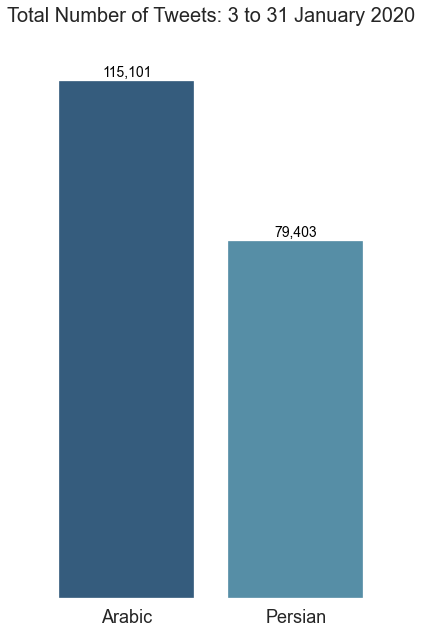

In [3]:
plt.figure(figsize=(6,10))
bars = plt.bar(['Arabic', 'Persian'], [len(df_ar), len(df_fa)], color=['#355c7d', '#568ea6'])
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, str(format(int(bar.get_height()), ',')), 
                 ha='center', color='black', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks([])
plt.grid(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title('Total Number of Tweets: 3 to 31 January 2020', fontsize = 20, y=1.05)
plt.savefig("figs/total_tweets.png", dpi=300)

In [4]:
df_ar_op = df_ar[df_ar['sentiment'] == 'O']
df_ar_op.reset_index(drop=True, inplace=True)

df_ar_su = df_ar[df_ar['sentiment'] == 'S']
df_ar_su.reset_index(drop=True, inplace=True)

df_ar_neu = df_ar[df_ar['sentiment'] == 'N']
df_ar_neu.reset_index(drop=True, inplace=True)

df_fa_op = df_fa[df_fa['sentiment'] == 'O']
df_fa_op.reset_index(drop=True, inplace=True)

df_fa_su = df_fa[df_fa['sentiment'] == 'S']
df_fa_su.reset_index(drop=True, inplace=True)

df_fa_neu = df_fa[df_fa['sentiment'] == 'N']
df_fa_neu.reset_index(drop=True, inplace=True)

## The percentage of tweets that oppose, support or are neutral about the assassination

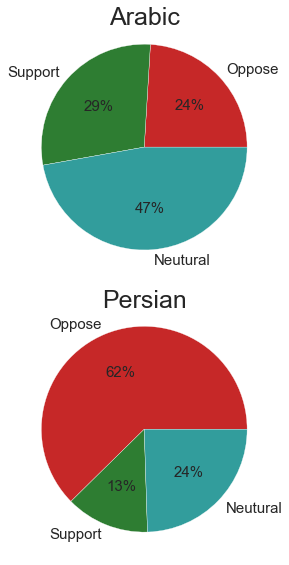

In [5]:
colors=['#c62828', '#2e7d32', '#329d9c']
labels=['Oppose','Support','Neutural']
plt.rcParams['axes.labelsize'] = 20
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
pieWedgesCollection1 = ax1.pie([len(df_ar_op), len(df_ar_su), len(df_ar_neu)], labels=labels, colors=colors,autopct='%.0f%%')
for l, p in zip(pieWedgesCollection1[1], pieWedgesCollection1[2]):
    l.set_fontsize(15)
    p.set_fontsize(15)
pieWedgesCollection2 = ax2.pie([len(df_fa_op), len(df_fa_su), len(df_fa_neu)],labels=labels, colors=colors,autopct='%.0f%%')
for l, p in zip(pieWedgesCollection2[1], pieWedgesCollection2[2]):
    l.set_fontsize(15)
    p.set_fontsize(15)
ax1.set_title("Arabic",fontsize=25, pad = 7)
ax2.set_title('Persian',fontsize=25)
ttl01 = ax1.title
ttl01.set_position([.5, 0.95])
ttl02 = ax2.title
ttl02.set_position([.5, 0.95])
fig.tight_layout()
plt.savefig("figs/percentage.png", dpi=300);

In [6]:
plt.style.use('seaborn')

## A breakdown of the number of users and their sentiments

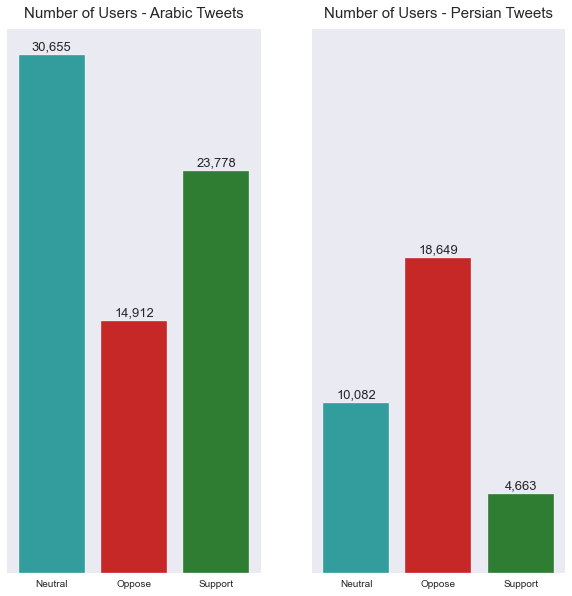

In [7]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(1, 2, 1)
labels = ['Neutral', 'Oppose', 'Support']
colors = ['#329d9c', '#c62828', '#2e7d32']
user_ar = pd.DataFrame(df_ar.groupby('sentiment')['username'].unique().apply(len))
ax1.bar(labels, user_ar.username, color=colors)
ax1.set_title("Number of Users - Arabic Tweets", fontsize = 15)
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
user_fa = pd.DataFrame(df_fa.groupby('sentiment')['username'].unique().apply(len))
ax2.bar(labels, user_fa.username, color=colors)
ax2.set_title("Number of Users - Persian Tweets", fontsize = 15)
for ax in (ax1, ax2):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 300, format(height, ','), ha="center", fontsize=13) 
    ax.set_yticks([])
    ax.grid(False)
    ttl = ax.title
    ttl.set_position([.5, 1.01])
plt.savefig("figs/users.png", dpi=300);

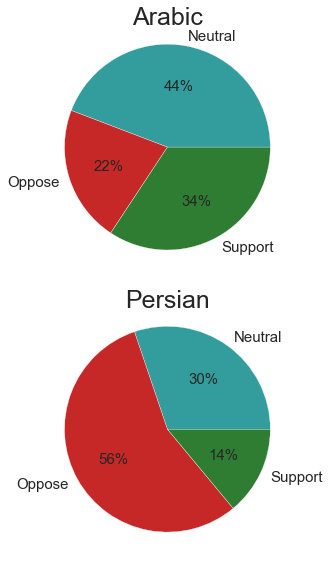

In [8]:
labels = ['Neutral', 'Oppose', 'Support']
colors = ['#329d9c', '#c62828', '#2e7d32']
plt.rcParams['axes.labelsize'] = 20
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
pieWedgesCollection1 = ax1.pie(user_ar.username, labels=labels, colors=colors,autopct='%.0f%%')
for l, p in zip(pieWedgesCollection1[1], pieWedgesCollection1[2]):
    l.set_fontsize(15)
    p.set_fontsize(15)
pieWedgesCollection2 = ax2.pie(user_fa.username,labels=labels, colors=colors,autopct='%.0f%%')
for l, p in zip(pieWedgesCollection2[1], pieWedgesCollection2[2]):
    l.set_fontsize(15)
    p.set_fontsize(15)
ax1.set_title("Arabic",fontsize=25, pad = 7)
ax2.set_title('Persian',fontsize=25)
ttl01 = ax1.title
ttl01.set_position([.5, 0.95])
ttl02 = ax2.title
ttl02.set_position([.5, 0.95])
fig.tight_layout()
plt.savefig("figs/user_percentage.png", dpi=300);

### Investigating if there are users that are tweeting in both Arabic and Farsi languages

In [9]:
users = list(set(df_ar['username']) & set(df_fa['username']))
print(len(users))
pivot_ar = df_ar[df_ar['username'].isin(users)].pivot_table(index='username', columns='sentiment', values='cleaned_text', aggfunc='count', margins=True)
pivot_fa = df_fa[df_fa['username'].isin(users)].pivot_table(index='username', columns='sentiment', values='cleaned_text', aggfunc='count', margins=True)
pivot_fa.columns += "_FA"
pivot_ar.columns += "_AR"
shared_users = pivot_ar.join(pivot_fa, how='inner')
shared_users.fillna(0, inplace=True)
shared_users['total'] = shared_users['All_AR'] + shared_users['All_FA']

2248


In [10]:
# Only users that have more than 5 tweets in both languages
top_shared = shared_users[(shared_users['All_AR'] > 5) & (shared_users['All_FA'] > 5)][:-1].sort_values('total', ascending=False)
print("Total Number of Tweets ",top_shared['total'].sum())
print(" ")
top_shared.style.background_gradient()

Total Number of Tweets  794
 


## Breakdown of how users interacted with the tweets

In [11]:
df_ar_op.loc[:, 'day'] = pd.to_datetime(df_ar_op.loc[:, 'date']).dt.day
df_ar_su.loc[:, 'day'] = pd.to_datetime(df_ar_su.loc[:, 'date']).dt.day
df_ar_neu.loc[:, 'day'] = pd.to_datetime(df_ar_neu.loc[:, 'date']).dt.day
df_fa_op.loc[:, 'day'] = pd.to_datetime(df_fa_op.loc[:, 'date']).dt.day
df_fa_su.loc[:, 'day'] = pd.to_datetime(df_fa_su.loc[:, 'date']).dt.day
df_fa_neu.loc[:, 'day'] = pd.to_datetime(df_fa_neu.loc[:, 'date']).dt.day

C:\Users\laura\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\laura\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
df_ar_op[['date', 'day']]

date  day
0      2020-01-01 22:40:43    1
1      2020-01-02 16:00:40    2
2      2020-01-02 19:21:59    2
3      2020-01-02 23:55:50    2
4      2020-01-03 00:27:12    3
...                    ...  ...
27667  2020-01-31 14:38:54   31
27668  2020-01-31 14:50:11   31
27669  2020-01-31 15:07:46   31
27670  2020-01-31 15:29:10   31
27671  2020-01-31 16:31:44   31

[27672 rows x 2 columns]

In [13]:
op_tw_freq_ar = {dt : len(df_ar_op[df_ar_op['day'] == dt]) for dt in df_ar_op['day'].unique() if dt > 2}
su_tw_freq_ar = {dt : len(df_ar_su[df_ar_su['day'] == dt]) for dt in df_ar_su['day'].unique() if dt > 2}
neu_tw_freq_ar = {dt : len(df_ar_neu[df_ar_neu['day'] == dt]) for dt in df_ar_neu['day'].unique() if dt > 2}
op_tw_freq_fa = {dt : len(df_fa_op[df_fa_op['day'] == dt]) for dt in df_fa_op['day'].unique() if dt > 2}
su_tw_freq_fa = {dt : len(df_fa_su[df_fa_su['day'] == dt]) for dt in df_fa_su['day'].unique() if dt > 2}
neu_tw_freq_fa = {dt : len(df_fa_neu[df_fa_neu['day'] == dt]) for dt in df_fa_neu['day'].unique() if dt > 2}

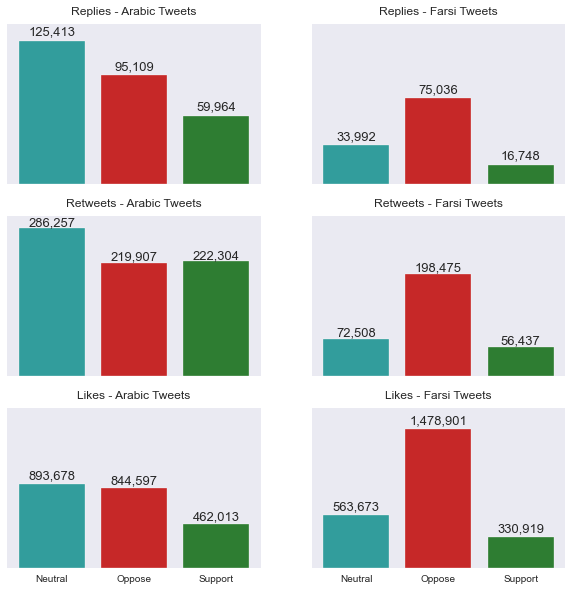

In [14]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(3, 2, 1)
labels = ['Neutral', 'Oppose', 'Support']
colors = ['#329d9c', '#c62828', '#2e7d32']
rep_ar = pd.DataFrame(df_ar.groupby('sentiment')['replies'].sum())
ax1.bar(labels, rep_ar.replies, color=colors)
ax1.set_ylim(0,140000)
ax1.set_title("Replies - Arabic Tweets")
ax2 = plt.subplot(3, 2, 2, sharey = ax1)
rep_fa = pd.DataFrame(df_fa.groupby('sentiment')['replies'].sum())
ax2.bar(labels, rep_fa.replies, color=colors)
ax2.set_title("Replies - Farsi Tweets")
ax3 = plt.subplot(3, 2, 3)
ret_ar = pd.DataFrame(df_ar.groupby('sentiment')['retweets'].sum())
ax3.bar(labels, ret_ar.retweets, color=colors)
ax3.set_ylim(0, 310000)
ax3.set_title("Retweets - Arabic Tweets")
ax4 = plt.subplot(3, 2, 4, sharey = ax3)
ret_fa = pd.DataFrame(df_fa.groupby('sentiment')['retweets'].sum())
ax4.bar(labels, ret_fa.retweets, color=colors)
ax4.set_title("Retweets - Farsi Tweets")
ax5 = plt.subplot(3, 2, 5)
l_ar = pd.DataFrame(df_ar.groupby('sentiment')['favorites'].sum())
ax5.bar(labels, l_ar.favorites, color=colors)
ax5.set_ylim(0, 1700000)
ax5.set_title("Likes - Arabic Tweets")
ax6 = plt.subplot(3, 2, 6, sharey = ax5)
l_fa = pd.DataFrame(df_fa.groupby('sentiment')['favorites'].sum())
ax6.bar(labels, l_fa.favorites, color=colors)
ax6.set_title("Likes - Farsi Tweets");
for ax in (ax1, ax2, ax3, ax4):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 5000, format(height, ','), ha="center", fontsize=13) 
    ax.set_yticks([])
    ax.grid(False)
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    
for ax in (ax5, ax6):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 50000, format(height, ','), ha="center", fontsize=13) 
    ax.set_yticks([])
    ax.grid(False)
    ttl = ax.title
    ttl.set_position([.5, 1.02])
for a in (ax1, ax2, ax3, ax4):
    a.set_xticks([])
plt.savefig("figs/interactions.png", dpi=300);

## How major news and events affected the sentiments of users, represented in percentages

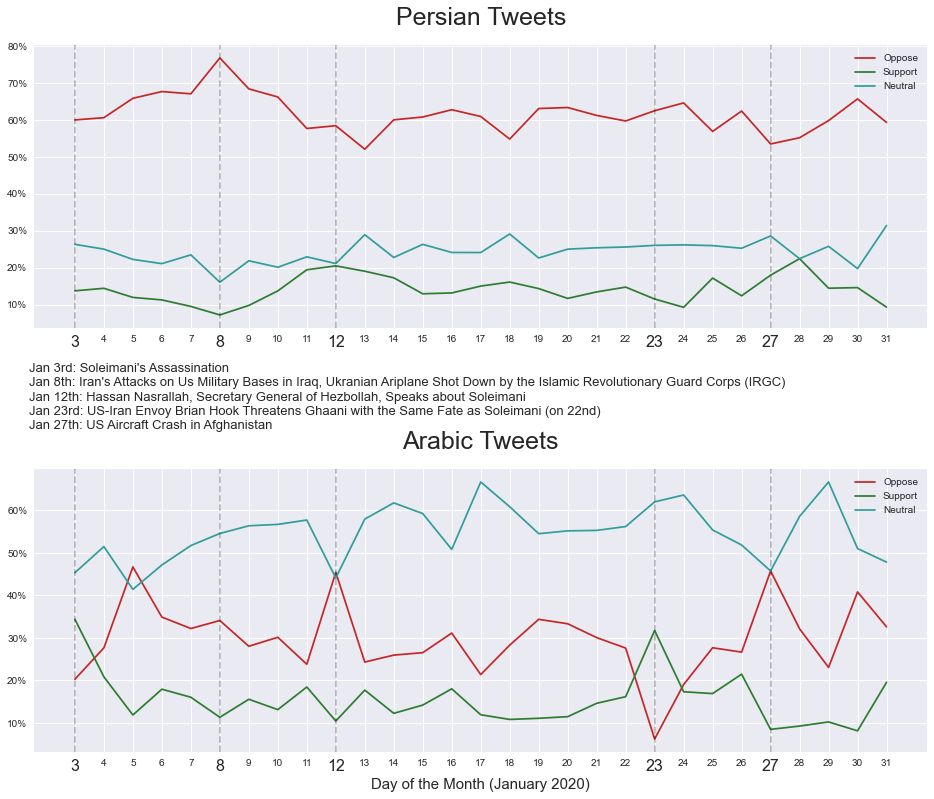

In [15]:
total_fa = np.array([op_tw_freq_fa[i] + su_tw_freq_fa[i] + neu_tw_freq_fa[i] for i in range(3,32)])
total_ar = np.array([op_tw_freq_ar[i] + su_tw_freq_ar[i] + neu_tw_freq_ar[i] for i in range(3,32)])
op_fa = np.array(list(op_tw_freq_fa.values())) / total_fa
su_fa = np.array(list(su_tw_freq_fa.values())) / total_fa
neu_fa = np.array(list(neu_tw_freq_fa.values())) / total_fa
op_ar = np.array(list(op_tw_freq_ar.values())) / total_ar
su_ar = np.array(list(su_tw_freq_ar.values())) / total_ar
neu_ar = np.array(list(neu_tw_freq_ar.values())) / total_ar

fig,(ax,ax2) = plt.subplots(2, 1, figsize=(16,13))

xvals = list(op_tw_freq_fa.keys())
fa_op = ax.plot(xvals, op_fa, color='#c62828', label='Oppose')
fa_su = ax.plot(xvals, su_fa, color='#2e7d32', label='Support')
fa_neu = ax.plot(xvals, neu_fa, color='#329d9c', label='Neutral')

ax.xaxis.set_ticks(xvals)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_title('Persian Tweets', fontsize=25)
ttl01 = ax.title
ttl01.set_position([.5, 1.05])
ax.legend()

ax2.plot(xvals, op_ar, color='#c62828', label='Oppose')
ax2.plot(xvals, su_ar, color='#2e7d32', label='Support')
ax2.plot(xvals, neu_ar, color='#329d9c', label='Neutral')
ax2.xaxis.set_ticks(xvals)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax2.set_title('Arabic Tweets', fontsize=25)
ttl02 = ax2.title
ttl02.set_position([.5, 1.05])
ax2.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
for a in (ax, ax2):
    ticks = a.xaxis.get_major_ticks()
    for i in [0, 5, 9, 20, 24]:
        ticks[i].label.set_fontsize(16)
        #ticks[i].label.set_color('red')
ax2.legend()

for i in [3, 8, 12, 23, 27]:
    ax.axvline(x=i, color='k', linestyle='--', alpha=0.25)
    ax2.axvline(x=i, color='k', linestyle='--', alpha = 0.25)

fig.subplots_adjust(hspace=0.5)

txt = """Jan 3rd: Soleimani's Assassination
Jan 8th: Iran's Attacks on Us Military Bases in Iraq, Ukranian Ariplane Shot Down by the Islamic Revolutionary Guard Corps (IRGC)
Jan 12th: Hassan Nasrallah, Secretary General of Hezbollah, Speaks about Soleimani
Jan 23rd: US-Iran Envoy Brian Hook Threatens Ghaani with the Same Fate as Soleimani (on 22nd)
Jan 27th: US Aircraft Crash in Afghanistan"""

plt.figtext(0.12, 0.47, txt, fontsize = 13)
plt.savefig("figs/sentiments_percentage.png", dpi=300);

## How major news and events affected the sentiments of users, represented in number of tweets

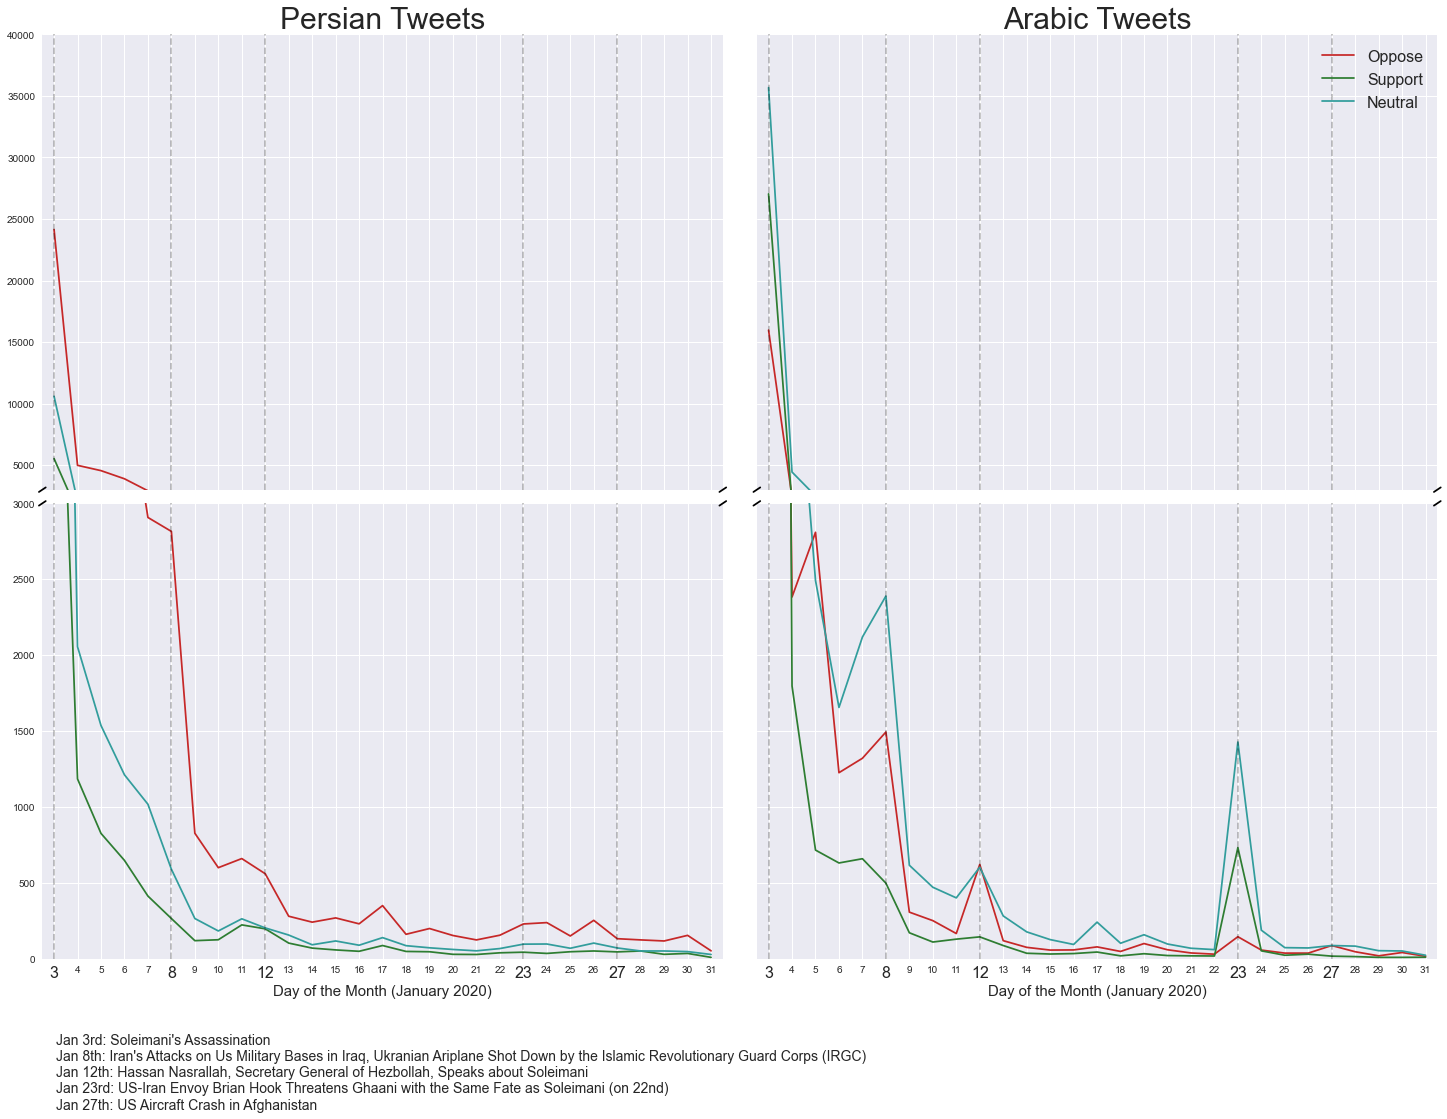

In [16]:
plt.figure(figsize=(25,17))
plt.subplots_adjust(hspace=0.03, wspace=0.05)
xvals = list(op_tw_freq_fa.keys())
opfa = list(op_tw_freq_fa.values())
sufa = list(su_tw_freq_fa.values())
neufa = list(neu_tw_freq_fa.values())

ax1 = plt.subplot(2, 2, 1)
ax1.plot(xvals, opfa, color='#c62828')
ax1.plot(xvals, sufa, color='#2e7d32')
ax1.plot(xvals, neufa, color='#329d9c')
ax1.xaxis.set_ticks(xvals)


ax2 = plt.subplot(2, 2, 3, sharex = ax1)
ax2.plot(xvals, opfa, color='#c62828')
ax2.plot(xvals, sufa, color='#2e7d32')
ax2.plot(xvals, neufa, color='#329d9c')
ax2.xaxis.set_ticks(xvals)

ax1.set(xlim=(2.5,31.5))
ax1.set_ylim(3000, 40000)  # outliers only
ax2.set_ylim(0, 3000)  # most of the data


plt.setp(ax1.get_xticklabels(), visible=False)
fig.text(0.1, 0.5, 'Number of Tweets', fontsize = 15, va='center', rotation='vertical')
ax2.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
ax1.set_title('Persian Tweets', fontsize = 30)

txt = """Jan 3rd: Soleimani's Assassination
Jan 8th: Iran's Attacks on Us Military Bases in Iraq, Ukranian Ariplane Shot Down by the Islamic Revolutionary Guard Corps (IRGC)
Jan 12th: Hassan Nasrallah, Secretary General of Hezbollah, Speaks about Soleimani
Jan 23rd: US-Iran Envoy Brian Hook Threatens Ghaani with the Same Fate as Soleimani (on 22nd)
Jan 27th: US Aircraft Crash in Afghanistan"""

ax2.text(0.02,-0.33, txt, size=14, ha="left", transform=ax2.transAxes)


opar = list(op_tw_freq_ar.values())
suar = list(su_tw_freq_ar.values())
neuar = list(neu_tw_freq_ar.values())

ax3 = plt.subplot(2, 2, 2)
ax3.plot(xvals, opar, color='#c62828', label='Oppose')
ax3.plot(xvals, suar, color='#2e7d32', label='Support')
ax3.plot(xvals, neuar, color='#329d9c', label='Neutral')
ax3.legend(fontsize=16, loc='upper right')
ax3.xaxis.set_ticks(xvals)

ax4 = plt.subplot(2, 2, 4, sharex = ax3)
ax4.plot(xvals, opar, color='#c62828')
ax4.plot(xvals, suar, color='#2e7d32')
ax4.plot(xvals, neuar, color='#329d9c')
ax4.xaxis.set_ticks(xvals)

ax3.set(xlim=(2.5,31.5))
ax3.set_ylim(3000, 40000)  # outliers only
ax4.set_ylim(0, 3000)  # most of the data

d = 0.005  # how big to make the diagonal lines in axes
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False) # top left axes
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom left axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the top right axes
ax3.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax3.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax4.transAxes)  # switch to the bottom right axes
ax4.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax4.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

for a in [ax1, ax2, ax3, ax4]:
    for i in [3, 8, 12, 23, 27]:
        a.axvline(x=i, color='k', linestyle='--', alpha=0.25)
        
for a in (ax2, ax4):
    ticks = a.xaxis.get_major_ticks()
    for i in [0, 5, 9, 20, 24]:
        ticks[i].label.set_fontsize(16)

fig.text(0.1, 0.5, 'Number of Tweets', fontsize = 15, va='center', rotation='vertical')
ax4.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
ax3.set_title('Arabic Tweets', fontsize = 30)


plt.savefig("figs/sentiments_numbers.png", dpi=300);

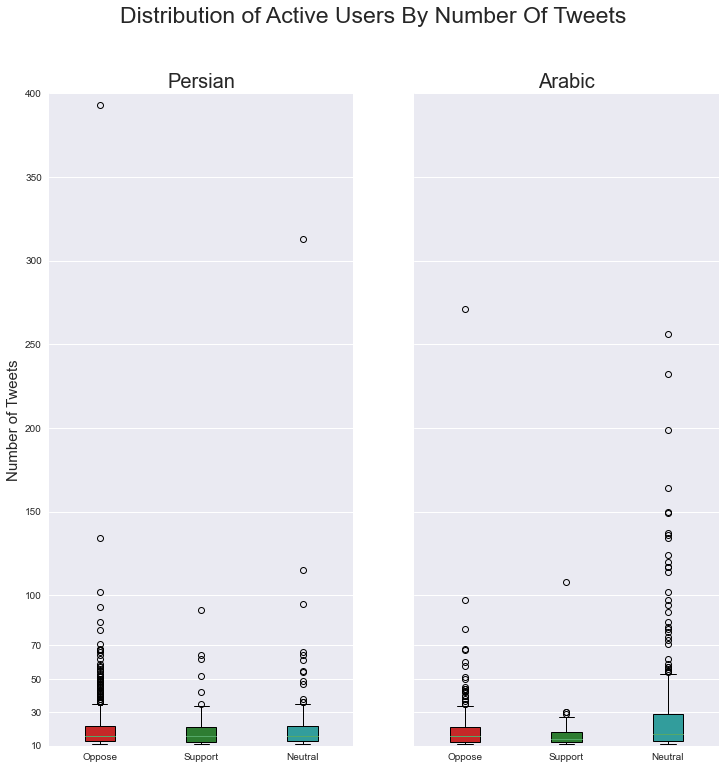

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,12), sharey=True)
bplot01 = ax1.boxplot([np.array([i for i in df_fa_op['username'].value_counts() if i > 10]), np.array([i for i in df_fa_su['username'].value_counts() if i > 10],), 
             np.array([i for i in df_fa_neu['username'].value_counts() if i > 10])], patch_artist=True, labels=["Oppose", "Support", "Neutral"])
ax1.set_title("Persian", fontsize=20)
ax1.set_ylabel('Number of Tweets', fontsize=15)
bplot02 = ax2.boxplot([np.array([i for i in df_ar_op['username'].value_counts() if i > 10]), np.array([i for i in df_ar_su['username'].value_counts() if i > 10],), 
             np.array([i for i in df_ar_neu['username'].value_counts() if i > 10])], patch_artist=True, labels=["Oppose", "Support", "Neutral"])
ax1.set_ylim(10,400)
ax1.yaxis.set_ticks([10, 30, 50, 70, 100, 150, 200, 250, 300, 350, 400])
ax2.set_title("Arabic", fontsize=20)

colors = ['#c62828', '#2e7d32', '#329d9c']
for bplot in (bplot01, bplot02):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)

plt.suptitle("Distribution of Active Users By Number Of Tweets", fontsize=23)

plt.savefig("figs/active_users_dist.png", dpi=300);

## How major news and events affected the sentiments of active users, represented in percentages

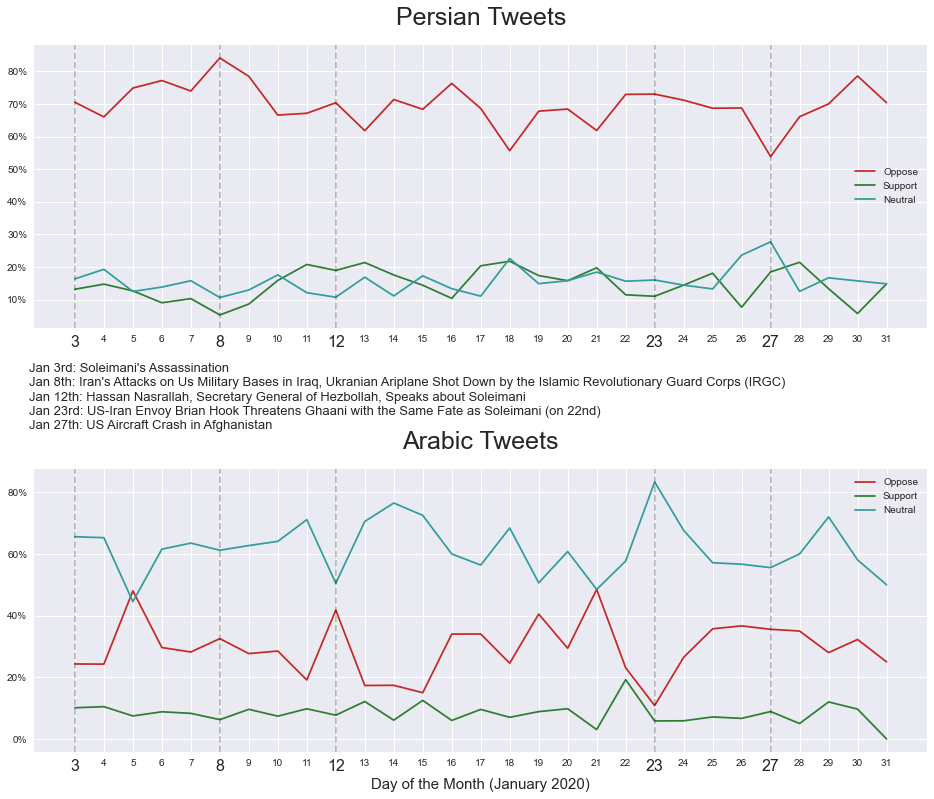

In [18]:
op_ar = df_ar_op[df_ar_op['username'].isin([k for k, v in df_ar_op['username'].value_counts().to_dict().items() if v > 9])]
op_tw_freq_ar = {dt : len(op_ar[op_ar['day'] == dt]) for dt in op_ar['day'].unique() if dt > 2}

su_ar = df_ar_su[df_ar_su['username'].isin([k for k, v in df_ar_su['username'].value_counts().to_dict().items() if v > 9])]
su_tw_freq_ar = {dt : len(su_ar[su_ar['day'] == dt]) for dt in su_ar['day'].unique() if dt > 2}

neu_ar = df_ar_neu[df_ar_neu['username'].isin([k for k, v in df_ar_neu['username'].value_counts().to_dict().items() if v > 9])]
neu_tw_freq_ar = {dt : len(neu_ar[neu_ar['day'] == dt]) for dt in neu_ar['day'].unique() if dt > 2}

op_fa = df_fa_op[df_fa_op['username'].isin([k for k, v in df_fa_op['username'].value_counts().to_dict().items() if v > 9])]
op_tw_freq_fa = {dt : len(op_fa[op_fa['day'] == dt]) for dt in op_fa['day'].unique() if dt > 2}

su_fa = df_fa_su[df_fa_su['username'].isin([k for k, v in df_fa_su['username'].value_counts().to_dict().items() if v > 9])]
su_tw_freq_fa = {dt : len(su_fa[su_fa['day'] == dt]) for dt in su_fa['day'].unique() if dt > 2}

neu_fa = df_fa_neu[df_fa_neu['username'].isin([k for k, v in df_fa_neu['username'].value_counts().to_dict().items() if v > 9])]
neu_tw_freq_fa = {dt : len(neu_fa[neu_fa['day'] == dt]) for dt in neu_fa['day'].unique() if dt > 2}

for d in [op_tw_freq_ar, su_tw_freq_ar, neu_tw_freq_ar, op_tw_freq_fa, su_tw_freq_fa, neu_tw_freq_fa]:
    for i in range(3,32):
        if i not in d:
            d[i] = 0


total_fa = np.array([op_tw_freq_fa[i] + su_tw_freq_fa[i] + neu_tw_freq_fa[i] for i in range(3,32)])
total_ar = np.array([op_tw_freq_ar[i] + su_tw_freq_ar[i] + neu_tw_freq_ar[i] for i in range(3,32)])
op_fa = np.array(list(op_tw_freq_fa.values())) / total_fa
su_fa = np.array(list(su_tw_freq_fa.values())) / total_fa
neu_fa = np.array(list(neu_tw_freq_fa.values())) / total_fa
op_ar = np.array(list(op_tw_freq_ar.values())) / total_ar
su_ar = np.array(list(su_tw_freq_ar.values())) / total_ar
neu_ar = np.array(list(neu_tw_freq_ar.values())) / total_ar

fig,(ax,ax2) = plt.subplots(2, 1, figsize=(16,13))

xvals = list(op_tw_freq_fa.keys())
fa_op = ax.plot(xvals, op_fa, color='#c62828', label='Oppose')
fa_su = ax.plot(xvals, su_fa, color='#2e7d32', label='Support')
fa_neu = ax.plot(xvals, neu_fa, color='#329d9c', label='Neutral')

ax.xaxis.set_ticks(xvals)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_title('Persian Tweets', fontsize=25)
ttl01 = ax.title
ttl01.set_position([.5, 1.05])
ax.legend()

ax2.plot(xvals, op_ar, color='#c62828', label='Oppose')
ax2.plot(xvals, su_ar, color='#2e7d32', label='Support')
ax2.plot(xvals, neu_ar, color='#329d9c', label='Neutral')
ax2.xaxis.set_ticks(xvals)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax2.set_title('Arabic Tweets', fontsize=25)
ttl02 = ax2.title
ttl02.set_position([.5, 1.05])
ax2.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
for a in (ax, ax2):
    ticks = a.xaxis.get_major_ticks()
    for i in [0, 5, 9, 20, 24]:
        ticks[i].label.set_fontsize(16)
        #ticks[i].label.set_color('red')
ax2.legend()

for i in [3, 8, 12, 23, 27]:
    ax.axvline(x=i, color='k', linestyle='--', alpha=0.25)
    ax2.axvline(x=i, color='k', linestyle='--', alpha = 0.25)

fig.subplots_adjust(hspace=0.5)

txt = """Jan 3rd: Soleimani's Assassination
Jan 8th: Iran's Attacks on Us Military Bases in Iraq, Ukranian Ariplane Shot Down by the Islamic Revolutionary Guard Corps (IRGC)
Jan 12th: Hassan Nasrallah, Secretary General of Hezbollah, Speaks about Soleimani
Jan 23rd: US-Iran Envoy Brian Hook Threatens Ghaani with the Same Fate as Soleimani (on 22nd)
Jan 27th: US Aircraft Crash in Afghanistan"""

plt.figtext(0.12, 0.47, txt, fontsize = 13)
plt.savefig("figs/active_users_percent.png", dpi=300);

## How major news and events affected the sentiments of active users, represented in number of tweets

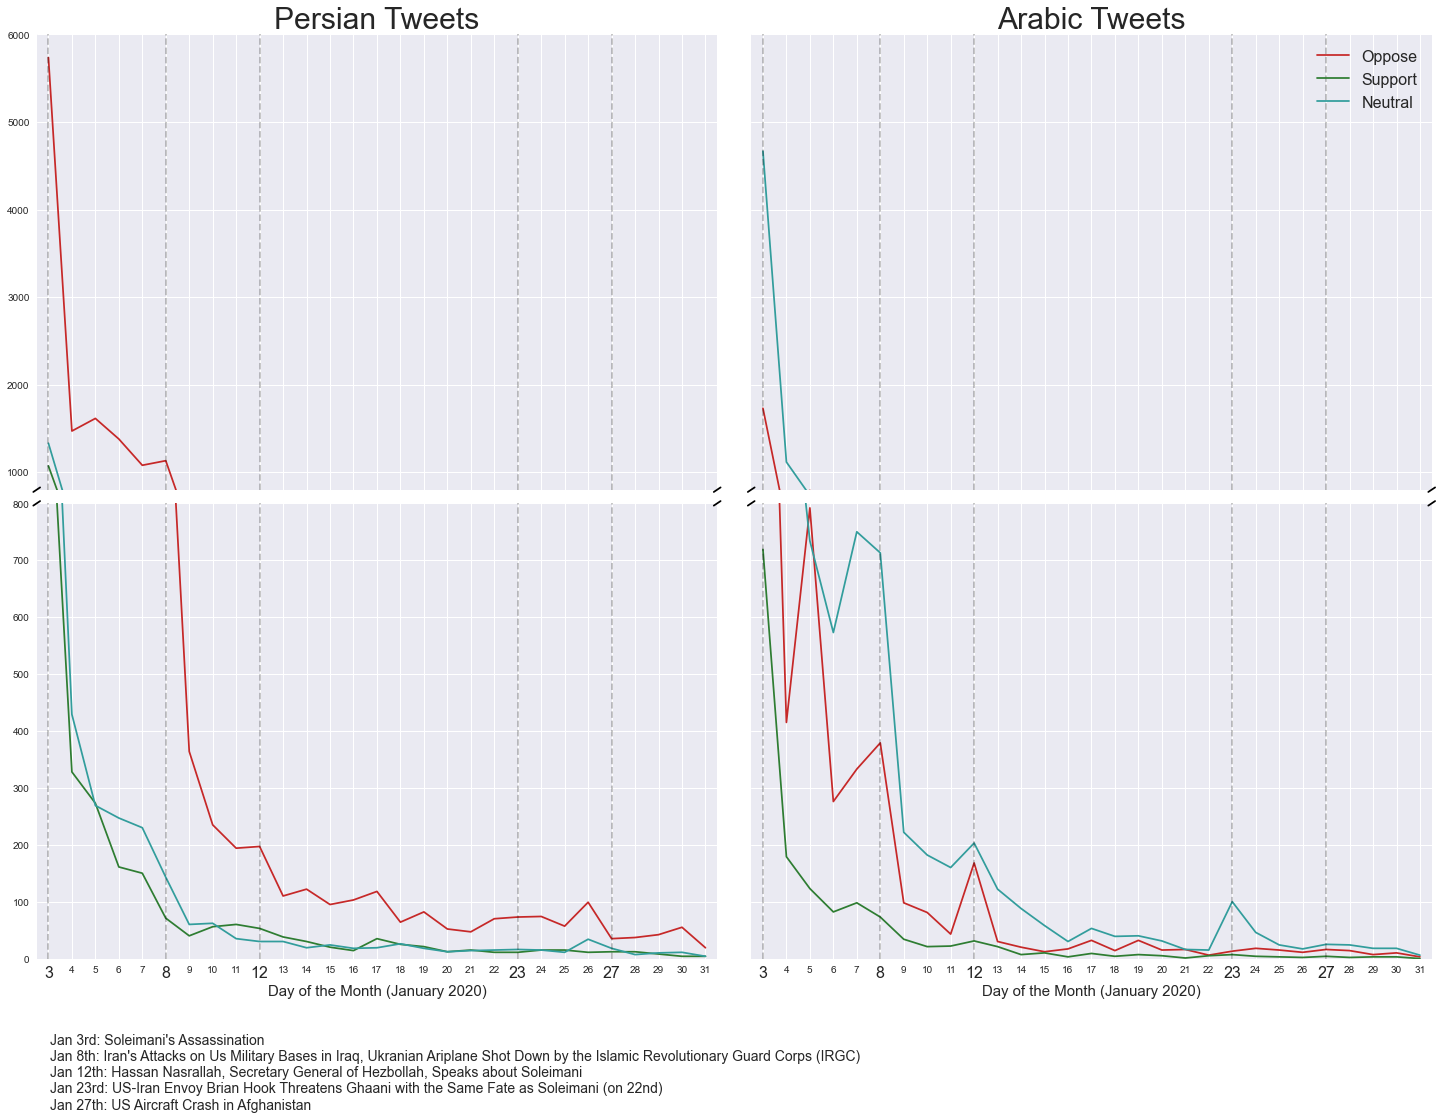

In [19]:
plt.figure(figsize=(25,17))
plt.subplots_adjust(hspace=0.03, wspace=0.05)
xvals = list(op_tw_freq_fa.keys())
opfa = list(op_tw_freq_fa.values())
sufa = list(su_tw_freq_fa.values())
neufa = list(neu_tw_freq_fa.values())

ax1 = plt.subplot(2, 2, 1)
ax1.plot(xvals, opfa, color='#c62828')
ax1.plot(xvals, sufa, color='#2e7d32')
ax1.plot(xvals, neufa, color='#329d9c')
ax1.xaxis.set_ticks(xvals)


ax2 = plt.subplot(2, 2, 3, sharex = ax1)
ax2.plot(xvals, opfa, color='#c62828')
ax2.plot(xvals, sufa, color='#2e7d32')
ax2.plot(xvals, neufa, color='#329d9c')
ax2.xaxis.set_ticks(xvals)

ax1.set(xlim=(2.5,31.5))
ax1.set_ylim(800, 6000)  # outliers only
ax2.set_ylim(0, 800)  # most of the data


plt.setp(ax1.get_xticklabels(), visible=False)
fig.text(0.1, 0.5, 'Number of Tweets', fontsize = 15, va='center', rotation='vertical')
ax2.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
ax1.set_title('Persian Tweets', fontsize = 30)

txt = """Jan 3rd: Soleimani's Assassination
Jan 8th: Iran's Attacks on Us Military Bases in Iraq, Ukranian Ariplane Shot Down by the Islamic Revolutionary Guard Corps (IRGC)
Jan 12th: Hassan Nasrallah, Secretary General of Hezbollah, Speaks about Soleimani
Jan 23rd: US-Iran Envoy Brian Hook Threatens Ghaani with the Same Fate as Soleimani (on 22nd)
Jan 27th: US Aircraft Crash in Afghanistan"""

ax2.text(0.02,-0.33, txt, size=14, ha="left", transform=ax2.transAxes)


opar = list(op_tw_freq_ar.values())
suar = list(su_tw_freq_ar.values())
neuar = list(neu_tw_freq_ar.values())

ax3 = plt.subplot(2, 2, 2)
ax3.plot(xvals, opar, color='#c62828', label='Oppose')
ax3.plot(xvals, suar, color='#2e7d32', label='Support')
ax3.plot(xvals, neuar, color='#329d9c', label='Neutral')
ax3.legend(fontsize=16, loc='upper right')
ax3.xaxis.set_ticks(xvals)

ax4 = plt.subplot(2, 2, 4, sharex = ax3)
ax4.plot(xvals, opar, color='#c62828')
ax4.plot(xvals, suar, color='#2e7d32')
ax4.plot(xvals, neuar, color='#329d9c')
ax4.xaxis.set_ticks(xvals)

ax3.set(xlim=(2.5,31.5))
ax3.set_ylim(800, 6000)  # outliers only
ax4.set_ylim(0, 800)  # most of the data

d = 0.005  # how big to make the diagonal lines in axes
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False) # top left axes
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom left axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the top right axes
ax3.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax3.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax4.transAxes)  # switch to the bottom right axes
ax4.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax4.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

for a in [ax1, ax2, ax3, ax4]:
    for i in [3, 8, 12, 23, 27]:
        a.axvline(x=i, color='k', linestyle='--', alpha=0.25)
        
for a in (ax2, ax4):
    ticks = a.xaxis.get_major_ticks()
    for i in [0, 5, 9, 20, 24]:
        ticks[i].label.set_fontsize(16)

fig.text(0.1, 0.5, 'Number of Tweets', fontsize = 15, va='center', rotation='vertical')
ax4.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
ax3.set_title('Arabic Tweets', fontsize = 30)
plt.savefig("figs/active_users_number.png", dpi=300);

## How major news and events affected the sentiments of less active users, represented in percentage

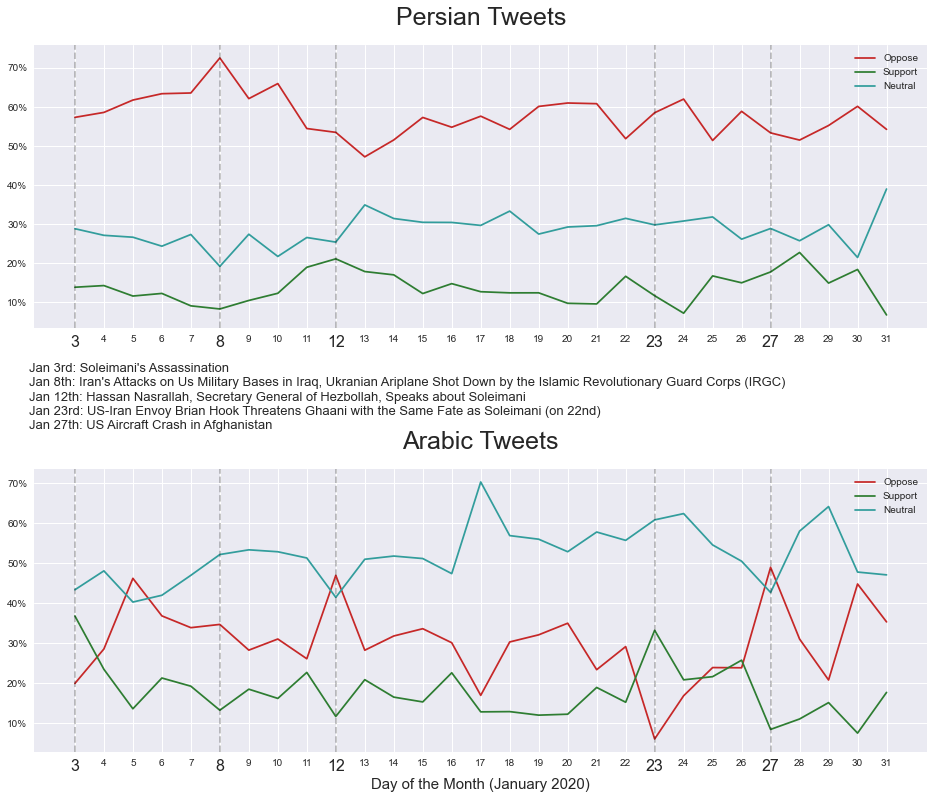

In [20]:
op_ar = df_ar_op[df_ar_op['username'].isin([k for k, v in df_ar_op['username'].value_counts().to_dict().items() if v < 10])]
op_tw_freq_ar = {dt : len(op_ar[op_ar['day'] == dt]) for dt in op_ar['day'].unique() if dt > 2}

su_ar = df_ar_su[df_ar_su['username'].isin([k for k, v in df_ar_su['username'].value_counts().to_dict().items() if v < 10])]
su_tw_freq_ar = {dt : len(su_ar[su_ar['day'] == dt]) for dt in su_ar['day'].unique() if dt > 2}

neu_ar = df_ar_neu[df_ar_neu['username'].isin([k for k, v in df_ar_neu['username'].value_counts().to_dict().items() if v < 10])]
neu_tw_freq_ar = {dt : len(neu_ar[neu_ar['day'] == dt]) for dt in neu_ar['day'].unique() if dt > 2}

op_fa = df_fa_op[df_fa_op['username'].isin([k for k, v in df_fa_op['username'].value_counts().to_dict().items() if v < 10])]
op_tw_freq_fa = {dt : len(op_fa[op_fa['day'] == dt]) for dt in op_fa['day'].unique() if dt > 2}

su_fa = df_fa_su[df_fa_su['username'].isin([k for k, v in df_fa_su['username'].value_counts().to_dict().items() if v < 10])]
su_tw_freq_fa = {dt : len(su_fa[su_fa['day'] == dt]) for dt in su_fa['day'].unique() if dt > 2}

neu_fa = df_fa_neu[df_fa_neu['username'].isin([k for k, v in df_fa_neu['username'].value_counts().to_dict().items() if v < 10])]
neu_tw_freq_fa = {dt : len(neu_fa[neu_fa['day'] == dt]) for dt in neu_fa['day'].unique() if dt > 2}

for d in [op_tw_freq_ar, su_tw_freq_ar, neu_tw_freq_ar, op_tw_freq_fa, su_tw_freq_fa, neu_tw_freq_fa]:
    for i in range(3,32):
        if i not in d:
            d[i] = 0


total_fa = np.array([op_tw_freq_fa[i] + su_tw_freq_fa[i] + neu_tw_freq_fa[i] for i in range(3,32)])
total_ar = np.array([op_tw_freq_ar[i] + su_tw_freq_ar[i] + neu_tw_freq_ar[i] for i in range(3,32)])
op_fa = np.array(list(op_tw_freq_fa.values())) / total_fa
su_fa = np.array(list(su_tw_freq_fa.values())) / total_fa
neu_fa = np.array(list(neu_tw_freq_fa.values())) / total_fa
op_ar = np.array(list(op_tw_freq_ar.values())) / total_ar
su_ar = np.array(list(su_tw_freq_ar.values())) / total_ar
neu_ar = np.array(list(neu_tw_freq_ar.values())) / total_ar

fig,(ax,ax2) = plt.subplots(2, 1, figsize=(16,13))

xvals = list(op_tw_freq_fa.keys())
fa_op = ax.plot(xvals, op_fa, color='#c62828', label='Oppose')
fa_su = ax.plot(xvals, su_fa, color='#2e7d32', label='Support')
fa_neu = ax.plot(xvals, neu_fa, color='#329d9c', label='Neutral')

ax.xaxis.set_ticks(xvals)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_title('Persian Tweets', fontsize=25)
ttl01 = ax.title
ttl01.set_position([.5, 1.05])
ax.legend()

ax2.plot(xvals, op_ar, color='#c62828', label='Oppose')
ax2.plot(xvals, su_ar, color='#2e7d32', label='Support')
ax2.plot(xvals, neu_ar, color='#329d9c', label='Neutral')
ax2.xaxis.set_ticks(xvals)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax2.set_title('Arabic Tweets', fontsize=25)
ttl02 = ax2.title
ttl02.set_position([.5, 1.05])
ax2.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
for a in (ax, ax2):
    ticks = a.xaxis.get_major_ticks()
    for i in [0, 5, 9, 20, 24]:
        ticks[i].label.set_fontsize(16)
        #ticks[i].label.set_color('red')
ax2.legend()

for i in [3, 8, 12, 23, 27]:
    ax.axvline(x=i, color='k', linestyle='--', alpha=0.25)
    ax2.axvline(x=i, color='k', linestyle='--', alpha = 0.25)

fig.subplots_adjust(hspace=0.5)

txt = """Jan 3rd: Soleimani's Assassination
Jan 8th: Iran's Attacks on Us Military Bases in Iraq, Ukranian Ariplane Shot Down by the Islamic Revolutionary Guard Corps (IRGC)
Jan 12th: Hassan Nasrallah, Secretary General of Hezbollah, Speaks about Soleimani
Jan 23rd: US-Iran Envoy Brian Hook Threatens Ghaani with the Same Fate as Soleimani (on 22nd)
Jan 27th: US Aircraft Crash in Afghanistan"""

plt.figtext(0.12, 0.47, txt, fontsize = 13)
plt.savefig("figs/less_active_users_percent.png", dpi=300);

## How major news and events affected the sentiments of less active users, represented in number on tweets

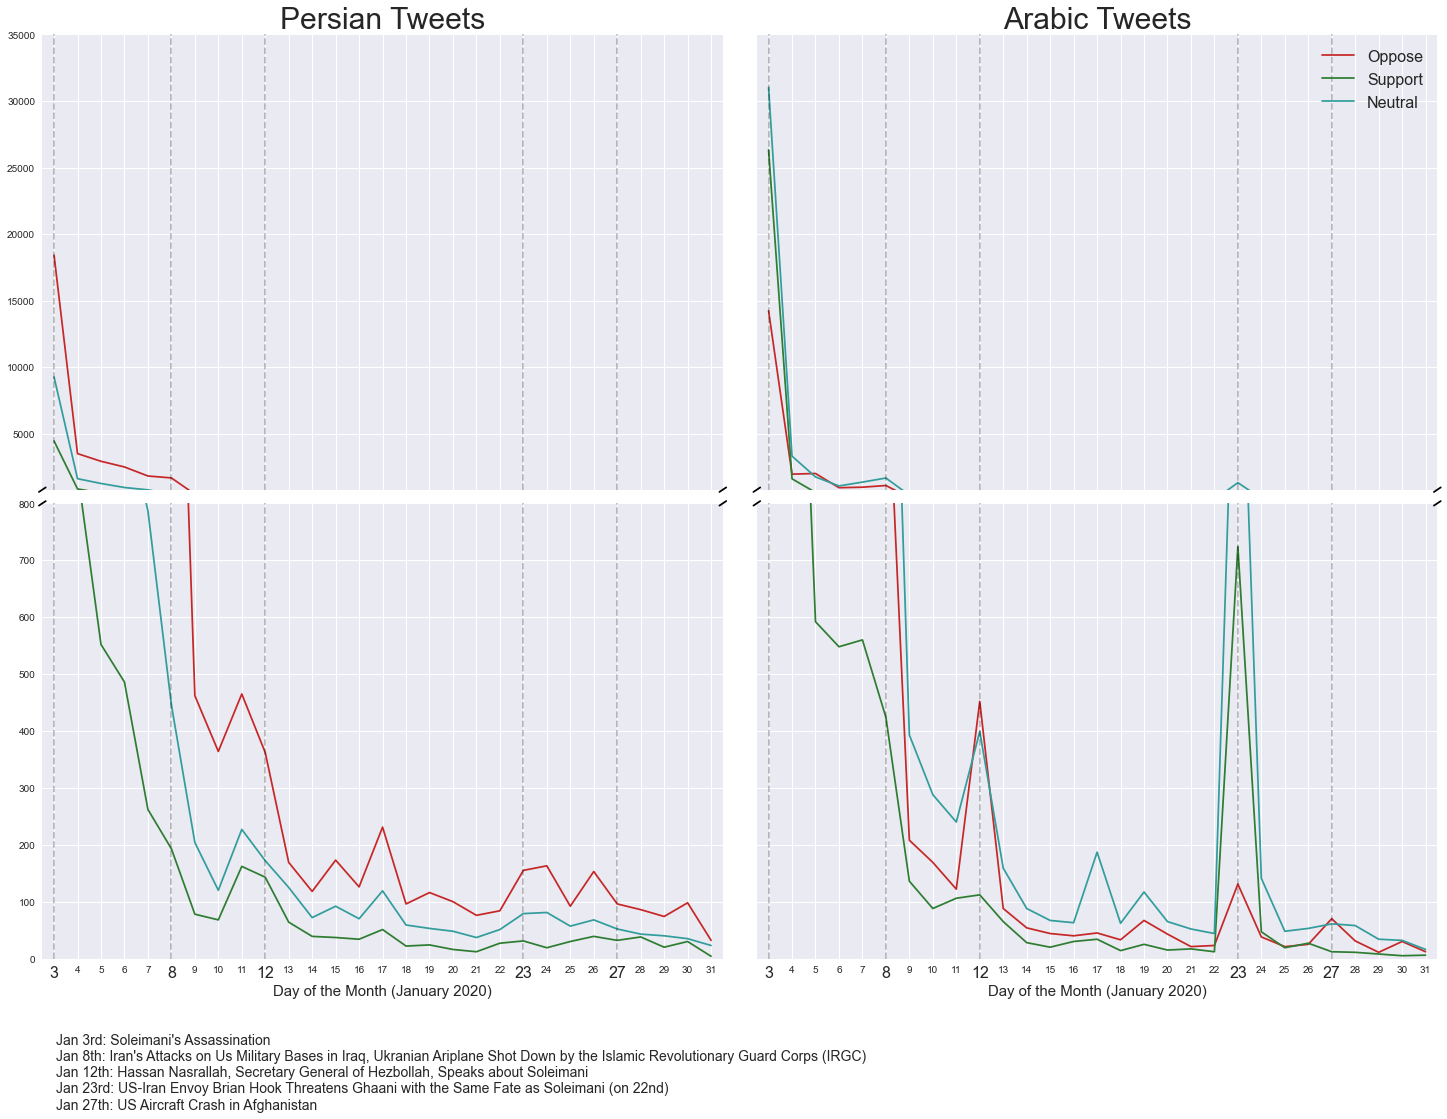

In [21]:
plt.figure(figsize=(25,17))
plt.subplots_adjust(hspace=0.03, wspace=0.05)
xvals = list(op_tw_freq_fa.keys())
opfa = list(op_tw_freq_fa.values())
sufa = list(su_tw_freq_fa.values())
neufa = list(neu_tw_freq_fa.values())

ax1 = plt.subplot(2, 2, 1)
ax1.plot(xvals, opfa, color='#c62828')
ax1.plot(xvals, sufa, color='#2e7d32')
ax1.plot(xvals, neufa, color='#329d9c')
ax1.xaxis.set_ticks(xvals)


ax2 = plt.subplot(2, 2, 3, sharex = ax1)
ax2.plot(xvals, opfa, color='#c62828')
ax2.plot(xvals, sufa, color='#2e7d32')
ax2.plot(xvals, neufa, color='#329d9c')
ax2.xaxis.set_ticks(xvals)

ax1.set(xlim=(2.5,31.5))
ax1.set_ylim(800, 35000)  # outliers only
ax2.set_ylim(0, 800)  # most of the data


plt.setp(ax1.get_xticklabels(), visible=False)
fig.text(0.1, 0.5, 'Number of Tweets', fontsize = 15, va='center', rotation='vertical')
ax2.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
ax1.set_title('Persian Tweets', fontsize = 30)

txt = """Jan 3rd: Soleimani's Assassination
Jan 8th: Iran's Attacks on Us Military Bases in Iraq, Ukranian Ariplane Shot Down by the Islamic Revolutionary Guard Corps (IRGC)
Jan 12th: Hassan Nasrallah, Secretary General of Hezbollah, Speaks about Soleimani
Jan 23rd: US-Iran Envoy Brian Hook Threatens Ghaani with the Same Fate as Soleimani (on 22nd)
Jan 27th: US Aircraft Crash in Afghanistan"""

ax2.text(0.02,-0.33, txt, size=14, ha="left", transform=ax2.transAxes)


opar = list(op_tw_freq_ar.values())
suar = list(su_tw_freq_ar.values())
neuar = list(neu_tw_freq_ar.values())

ax3 = plt.subplot(2, 2, 2)
ax3.plot(xvals, opar, color='#c62828', label='Oppose')
ax3.plot(xvals, suar, color='#2e7d32', label='Support')
ax3.plot(xvals, neuar, color='#329d9c', label='Neutral')
ax3.legend(fontsize=16, loc='upper right')
ax3.xaxis.set_ticks(xvals)

ax4 = plt.subplot(2, 2, 4, sharex = ax3)
ax4.plot(xvals, opar, color='#c62828')
ax4.plot(xvals, suar, color='#2e7d32')
ax4.plot(xvals, neuar, color='#329d9c')
ax4.xaxis.set_ticks(xvals)

ax3.set(xlim=(2.5,31.5))
ax3.set_ylim(800, 35000)  # outliers only
ax4.set_ylim(0, 800)  # most of the data

d = 0.005  # how big to make the diagonal lines in axes
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False) # top left axes
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom left axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the top right axes
ax3.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax3.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax4.transAxes)  # switch to the bottom right axes
ax4.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax4.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

for a in [ax1, ax2, ax3, ax4]:
    for i in [3, 8, 12, 23, 27]:
        a.axvline(x=i, color='k', linestyle='--', alpha=0.25)
        
for a in (ax2, ax4):
    ticks = a.xaxis.get_major_ticks()
    for i in [0, 5, 9, 20, 24]:
        ticks[i].label.set_fontsize(16)

fig.text(0.1, 0.5, 'Number of Tweets', fontsize = 15, va='center', rotation='vertical')
ax4.set_xlabel('Day of the Month (January 2020)', fontsize = 15)
ax3.set_title('Arabic Tweets', fontsize = 30)
plt.savefig("figs/less_active_users_number.png", dpi=300);

## Breakdown of most frequently used words by language and sentiment

In [22]:
text = " ".join(review for review in df_ar_op['cleaned_text'])
stop_ar = stopwords.words('arabic')
stop_ar = stop_ar + ['و', 'قاسم', 'سليماني', 'ان', 'الى', '..', '.', '،', ':', 'او', 'ل', 'قبل', '...', 'اي', '|', '"', 'Soleimani', '!', '؟', '?', '!!', 'الله', 'العراق', 'ايران']

In [23]:
def top_words_dict(txt: str, stop_words:list) -> dict:
    top_words = {}
    for w in txt.split():
        if w in stop_words:
            continue
        elif w not in top_words:
            top_words[w] = 1
        else:
            top_words[w] += 1
    return {k: v for k, v in sorted(top_words.items(), key=lambda item: item[1], reverse = True)}

In [24]:
top_words = top_words_dict(txt=text, stop_words=stop_ar)

In [25]:
def take(n: int, iterable: Iterable) -> list:
    "Return first n items of the iterable as a list."
    return list(itertools.islice(iterable, n))
for_wc = take(400, top_words.items())

In [26]:
def reshape_data(l: list) -> dict:
    """
    Arguments:
    l: a list of touples of lenght 2: (word, frequency)
    
    Connects Arabic/Persian letters and reshape them from right to left
    
    'reshape' is imported from 'arabic_reshaper' module and connects the letters
    'get_display' is imported from bidi.algorithm and reshape the letters right to left
    
    return a dictionary of words and frequencies.
    """
    return {get_display(reshape(t[0])) : t[1] for t in l}
    

In [27]:
dic_data = reshape_data(for_wc)

In [29]:
 def plot_wordCloud(color: str, font_path: str, language:str, sentiment:str, data:dict, size:Tuple[int, int]=(16,8), title_size: int =30) -> None:
        wc = WordCloud(background_color=color, width=1600, height=800,max_words=400, font_path=font_path).generate_from_frequencies(data)
        plt.figure(figsize=size)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'{language} Tweets - {sentiment} the Assassination', fontsize = title_size, y=1.05)
        plt.savefig(f"figs/wordcloud_{language}_{sentiment}.png", dpi=300);

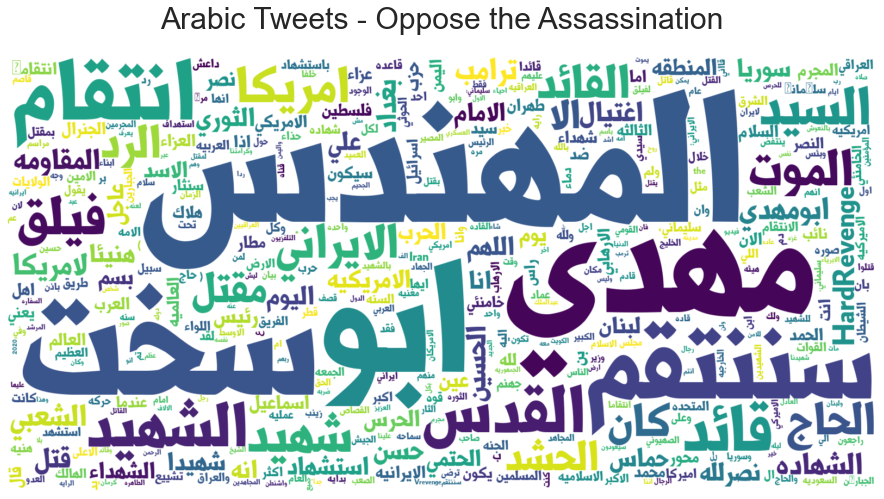

In [30]:
plot_wordCloud(color="white", font_path='Data/fonts/Shoroq.ttf', language='Arabic', sentiment='Oppose', data=dic_data)

In [31]:
print(for_wc[:100])

[('المهندس', 5228), ('مهدي', 3813), ('ابو', 3758), ('سخت', 3751), ('سننتقم', 3563), ('انتقام', 3399), ('القدس', 3370), ('قائد', 3183), ('الشهيد', 3008), ('فيلق', 2197), ('السيد', 2156), ('شهيد', 2063), ('الموت', 1955), ('امريكا', 1929), ('الايراني', 1787), ('القائد', 1770), ('الرد', 1703), ('كان', 1682), ('الحاج', 1680), ('مقتل', 1444), ('الحشد', 1386), ('الا', 1299), ('ابومهدي', 1266), ('ترامب', 1228), ('لامريكا', 1179), ('الشهاده', 1169), ('HardRevenge', 1166), ('الشعبي', 1156), ('المقاومه', 1095), ('الحسين', 1026), ('حسن', 1018), ('اغتيال', 1013), ('قتل', 999), ('بغداد', 974), ('علي', 896), ('الثوري', 875), ('اللهم', 866), ('نصرالله', 856), ('اليوم', 855), ('حماس', 850), ('شهيدا', 818), ('هنيئا', 795), ('انا', 788), ('سوريا', 782), ('الامام', 778), ('انه', 777), ('استشهاد', 770), ('الامريكيه', 769), ('الحتمي', 757), ('الحرب', 755), ('المنطقه', 747), ('لبنان', 741), ('عاجل', 712), ('الشهداء', 706), ('بسم', 705), ('الحرس', 703), ('الاسد', 678), ('عين', 631), ('رئيس', 627), ('نصر', 622

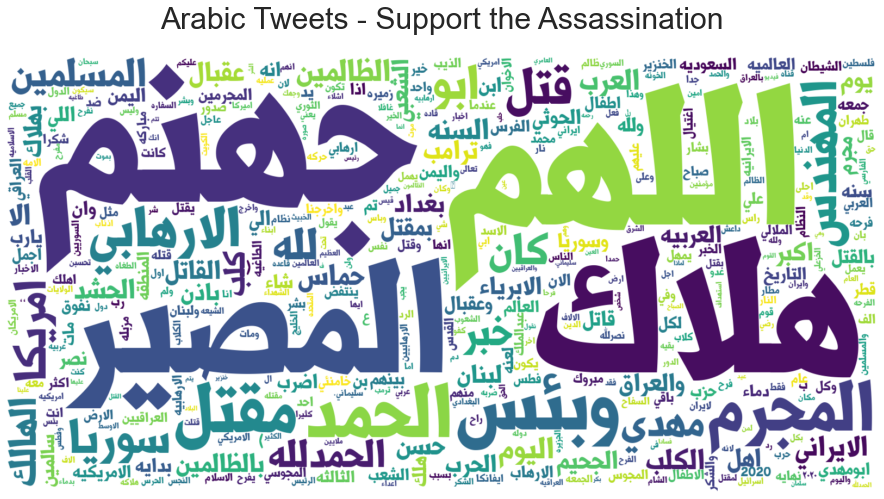

In [32]:
text = " ".join(review for review in df_ar_su['cleaned_text'])
top_words = top_words_dict(txt=text, stop_words=stop_ar)
for_wc = take(400, top_words.items())
dic_data = reshape_data(for_wc)
plot_wordCloud(color="white", font_path='Data/fonts/Shoroq.ttf', language='Arabic', sentiment='Support', data=dic_data)

In [33]:
print(for_wc[:100])

[('جهنم', 5037), ('اللهم', 4400), ('هلاك', 4101), ('المصير', 3570), ('وبئس', 3342), ('الحمد', 3081), ('المجرم', 3046), ('مقتل', 2970), ('الارهابي', 2945), ('قتل', 2416), ('المهندس', 2333), ('ابو', 2111), ('سوريا', 2089), ('امريكا', 1844), ('لله', 1816), ('كان', 1731), ('خبر', 1611), ('مهدي', 1603), ('المسلمين', 1563), ('الحمدلله', 1477), ('الهالك', 1446), ('الظالمين', 1398), ('اليوم', 1307), ('كلب', 1302), ('السنه', 1237), ('الا', 1235), ('حماس', 1226), ('العرب', 1219), ('الكلب', 1129), ('الايراني', 1111), ('الحشد', 1068), ('حسن', 1064), ('عقبال', 1033), ('ترامب', 1006), ('القاتل', 988), ('بالظالمين', 971), ('بغداد', 935), ('يوم', 923), ('بهلاك', 921), ('اهل', 919), ('اكبر', 911), ('لبنان', 891), ('الجحيم', 889), ('بمقتل', 884), ('الابرياء', 856), ('والعراق', 854), ('الحرب', 849), ('العربيه', 831), ('الشعبي', 830), ('باذن', 815), ('الحوثي', 812), ('مجرم', 802), ('الي', 772), ('قاتل', 769), ('ابن', 762), ('اللي', 761), ('هلك', 742), ('وسوريا', 728), ('اضرب', 725), ('نصر', 721), ('انه', 

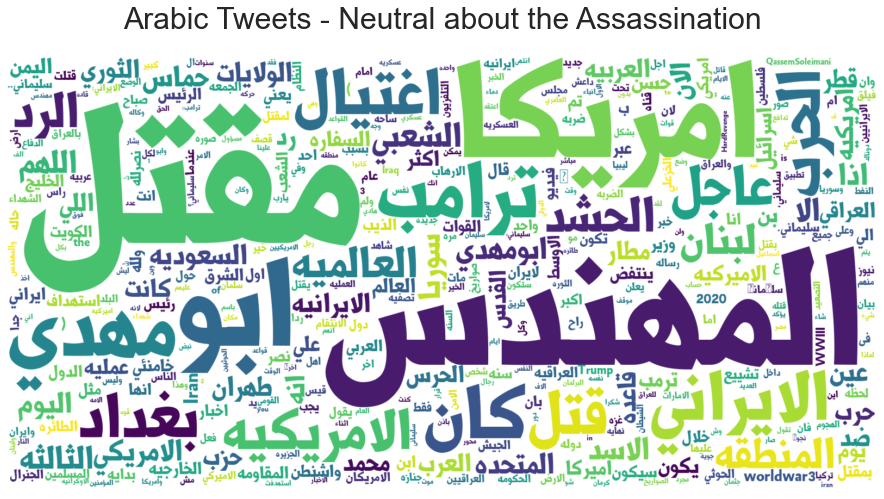

In [34]:
text = " ".join(review for review in df_ar_neu['cleaned_text'])
top_words = top_words_dict(txt=text, stop_words=stop_ar)
for_wc = take(400, top_words.items())
dic_data = reshape_data(for_wc)
plot_wordCloud(color="white", font_path='Data/fonts/Shoroq.ttf', language='Arabic', sentiment='Neutral about', data=dic_data)

In [35]:
print(for_wc[:100])

[('مقتل', 5677), ('المهندس', 4898), ('امريكا', 4448), ('ابو', 3699), ('مهدي', 3637), ('ترامب', 3030), ('كان', 2712), ('الايراني', 2695), ('اغتيال', 2301), ('بغداد', 2127), ('الحرب', 2083), ('قتل', 2038), ('الامريكيه', 2019), ('عاجل', 1995), ('الرد', 1539), ('الحشد', 1504), ('العالميه', 1434), ('المنطقه', 1410), ('لبنان', 1405), ('الشعبي', 1402), ('الا', 1238), ('الثالثه', 1229), ('اللهم', 1195), ('الاسد', 1177), ('سوريا', 1150), ('ابومهدي', 1148), ('اذا', 1146), ('الامريكي', 1141), ('اليوم', 1115), ('حماس', 1115), ('المتحده', 1103), ('الان', 1046), ('السعوديه', 1039), ('انه', 992), ('عين', 983), ('طهران', 965), ('الولايات', 959), ('الايرانيه', 919), ('حرب', 899), ('قطر', 875), ('حزب', 872), ('مطار', 863), ('قاعده', 855), ('ضد', 842), ('الثوري', 840), ('رد', 836), ('العربيه', 835), ('كانت', 820), ('اللي', 813), ('العرب', 808), ('امريكيه', 807), ('محمد', 805), ('الحرس', 788), ('القدس', 778), ('بن', 758), ('العراقي', 750), ('الاميركيه', 743), ('يوم', 729), ('عمليه', 726), ('اكثر', 723), (

In [36]:
stop_fa = open('Data/persian.txt', 'r', encoding="utf8").read().split()
stop_fa += ['سلیمانی', 'soleimani']

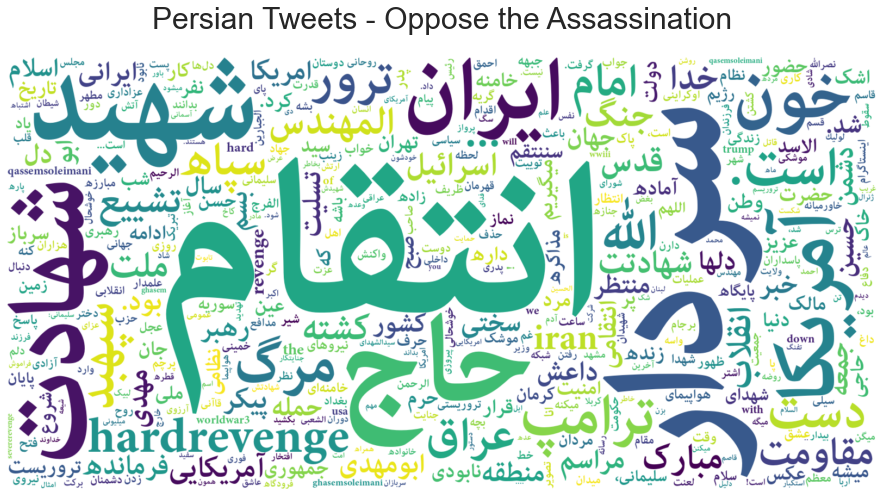

In [37]:
text = " ".join(review for review in df_fa_op['cleaned_text'])
top_words = top_words_dict(txt=text, stop_words=stop_fa)
for_wc = take(400, top_words.items())
dic_data = reshape_data(for_wc)
plot_wordCloud(color="white", font_path='Data/fonts/adobe-arabic/AdobeArabic-Bold.otf', language='Persian', sentiment='Oppose', data=dic_data)

In [38]:
print(for_wc[:100])

[('قاسم', 60081), ('انتقام', 25384), ('سردار', 13922), ('حاج', 9779), ('شهید', 9599), ('شهادت', 7383), ('ایران', 6949), ('آمریکا', 6021), ('خون', 4065), ('مرگ', 2898), ('ترامپ', 2758), ('الله', 2655), ('است.', 2385), ('hardrevenge', 2377), ('دست', 2327), ('ترور', 2319), ('سپهبد', 2267), ('عراق', 2137), ('...', 2035), ('امام', 2023), ('سپاه', 1942), ('المهندس', 1859), ('مقاومت', 1795), ('تشییع', 1727), ('جنگ', 1704), ('iran', 1686), ('خدا', 1619), ('ملت', 1594), ('کشته', 1577), ('مبارک', 1538), ('انقلاب', 1461), ('قدس', 1445), ('اسرائیل', 1421), ('شهادتت', 1409), ('آمریکایی', 1339), ('داعش', 1273), ('خبر', 1273), ('ابومهدی', 1267), ('مهدی', 1261), ('پیکر', 1249), ('فرمانده', 1205), ('مراسم', 1199), ('امریکا', 1198), ('منطقه', 1179), ('دل', 1171), ('ایرانی', 1168), ('بود.', 1164), ('رهبر', 1136), ('سختی', 1129), ('حمله', 1125), ('کشور', 1067), ('شد.', 1053), ('تسلیت', 1046), ('دلها', 1038), ('اسلام', 1024), ('دشمن', 1021), ('منتظر', 1016), ('حسین', 1003), ('جهان', 977), ('انتقامی', 972),

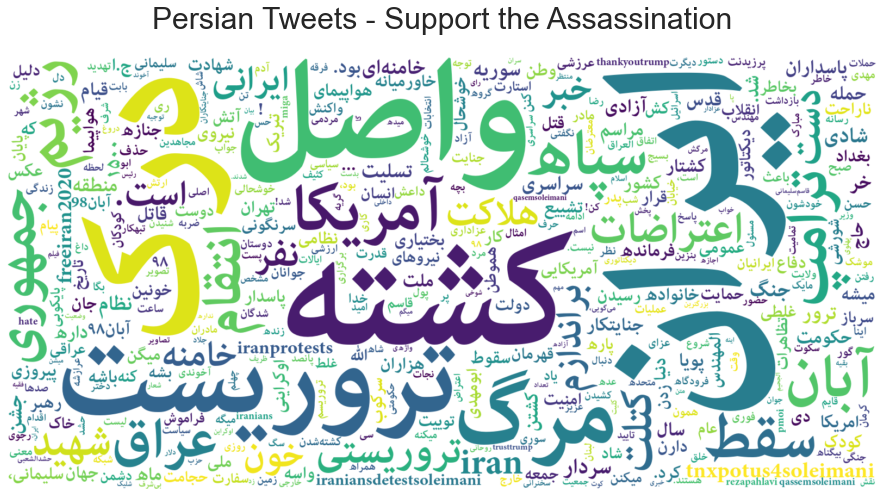

In [39]:
text = " ".join(review for review in df_fa_su['cleaned_text'])
top_words = top_words_dict(txt=text, stop_words=stop_fa)
for_wc = take(400, top_words.items())
dic_data = reshape_data(for_wc)
plot_wordCloud(color="white", font_path='Data/fonts/adobe-arabic/AdobeArabic-Bold.otf', language='Persian', sentiment='Support', data=dic_data)

In [40]:
print(for_wc[:100])

[('قاسم', 13736), ('ایران', 2549), ('درک', 1508), ('کشته', 1432), ('واصل', 1410), ('تروریست', 1338), ('مرگ', 1185), ('آمریکا', 1057), ('سپاه', 1001), ('رژیم', 971), ('سقط', 915), ('آبان', 894), ('ترامپ', 866), ('عراق', 787), ('جمهوری', 776), ('انتقام', 757), ('اعتراضات', 687), ('شهید', 652), ('کتلت', 649), ('تروریستی', 615), ('دست', 579), ('نفر', 568), ('خبر', 535), ('هلاکت', 534), ('براندازم', 533), ('است.', 508), ('خون', 506), ('iran', 504), ('خامنه', 497), ('ایرانی', 492), ('tnxpotus4soleimani', 488), ('سردار', 482), ('جنگ', 472), ('شادی', 468), ('freeiran2020', 450), ('خامنه\u200cای', 427), ('خر', 418), ('تسلیت', 396), ('ترور', 396), ('نظام', 395), ('سراسری', 390), ('سوریه', 386), ('شد.', 366), ('جشن', 365), ('سال', 344), ('پاسداران', 342), ('منطقه', 340), ('آزادی', 336), ('قدس', 329), ('حمله', 324), ('قاتل', 321), ('۱۵۰۰', 321), ('جنایتکار', 314), ('کشتن', 314), ('ماه', 311), ('iranprotests', 310), ('بود.', 307), ('حکومت', 302), ('پویا', 299), ('ملت', 296), ('قیام', 294), ('مراسم'

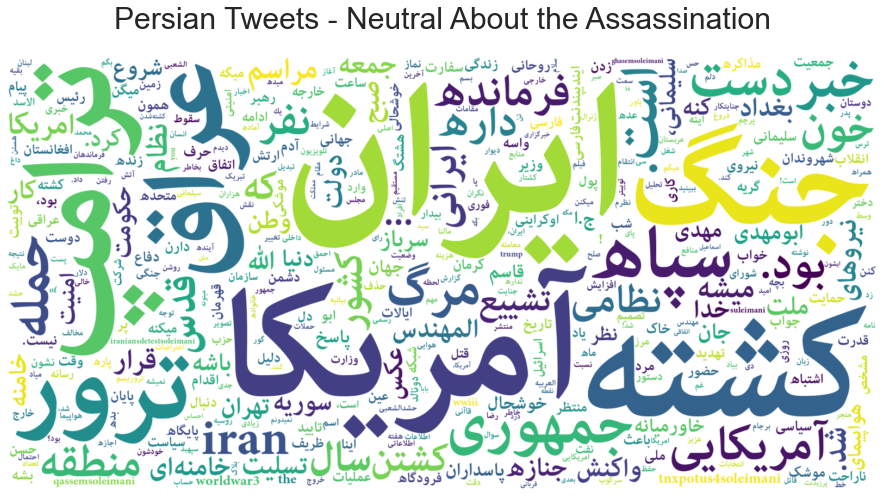

In [41]:
text = " ".join(review for review in df_fa_neu['cleaned_text'])
top_words = top_words_dict(txt=text, stop_words=stop_fa)
for_wc = take(400, top_words.items())
dic_data = reshape_data(for_wc)
plot_wordCloud(color="white", font_path='Data/fonts/adobe-arabic/AdobeArabic-Bold.otf', language='Persian', sentiment='Neutral About', data=dic_data)

In [42]:
print(for_wc[:100])

[('قاسم', 20950), ('ایران', 3378), ('آمریکا', 2134), ('کشته', 2008), ('جنگ', 1433), ('ترامپ', 1429), ('عراق', 1132), ('ترور', 1045), ('سپاه', 982), ('جمهوری', 950), ('خبر', 884), ('مرگ', 826), ('حمله', 805), ('است.', 780), ('دست', 735), ('iran', 675), ('آمریکایی', 608), ('بود.', 526), ('فرمانده', 518), ('نفر', 507), ('منطقه', 503), ('خون', 499), ('قدس', 489), ('داره', 480), ('سال', 479), ('نظامی', 473), ('...', 470), ('كه', 460), ('ایرانی', 458), ('کشور', 456), ('انتقام', 455), ('کشتن', 450), ('تشییع', 439), ('شد.', 433), ('مراسم', 429), ('امریکا', 427), ('میشه', 419), ('نظام', 416), ('قرار', 398), ('جمعه', 359), ('الله', 353), ('خامنه\u200cای', 351), ('بغداد', 348), ('المهندس', 344), ('واکنش', 339), ('نیروهای', 338), ('خدا', 334), ('تسلیت', 327), ('کار', 324), ('جنازه', 323), ('ملت', 318), ('عکس', 318), ('دولت', 310), ('سوریه', 309), ('صبح', 308), ('خامنه', 301), ('تهران', 296), ('وطن', 295), ('باشه', 285), ('حکومت', 282), ('سلیمانی،', 277), ('امنیت', 271), ('شروع', 267), ('کرد.', 263